In [1]:
import pandas as pd
import rioxarray as rxr
import xarray as xr
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

from xrspatial import aspect, slope

warnings.filterwarnings("ignore", category=FutureWarning)

from spicy_snow.retrieval import retrieval_from_parameters

In [2]:
# data = xr.open_dataset('~/scratch/spicy/SnowEx-Data/Banner_2021-03-15.nc')
data = xr.open_dataset('/Users/rdcrlzh1/Documents/spicy-analysis/data/SnowEx-Data/Banner_2021-03-15.nc')
# data = xr.open_dataset('~/spicy-snow/SnowEx-Data/Banner_2021-03-15.nc')
fig_dir = Path('/bsuhome/zacharykeskinen/spicy-analysis/figures/factors/banner')
fig_dir = Path('/Users/rdcrlzh1/Documents/spicy-analysis/figures')

In [3]:
# data = retrieval_from_parameters(data, A = 1.5, B = 0.1, C = 0.60)

In [4]:
data['inc'] = data['s1'].sel(band = 'inc').mean('time')
data['aspect'] = aspect(data['lidar-dem']) - 45

In [5]:
x, y = data['lidar-sd'], data['snow_depth'].sel(time = '2021-03-15', method = 'nearest')
idx = (~np.isnan(x)) & (~np.isnan(y))
idx.sum()

<xarray.DataArray ()>
array(16692)
Coordinates:
    projection      int64 0
    time            datetime64[ns] 2021-03-15T01:35:59
    flight_dir      object ...
    platform        object ...
    relative_orbit  float64 ...
    absolute_orbit  float64 ...

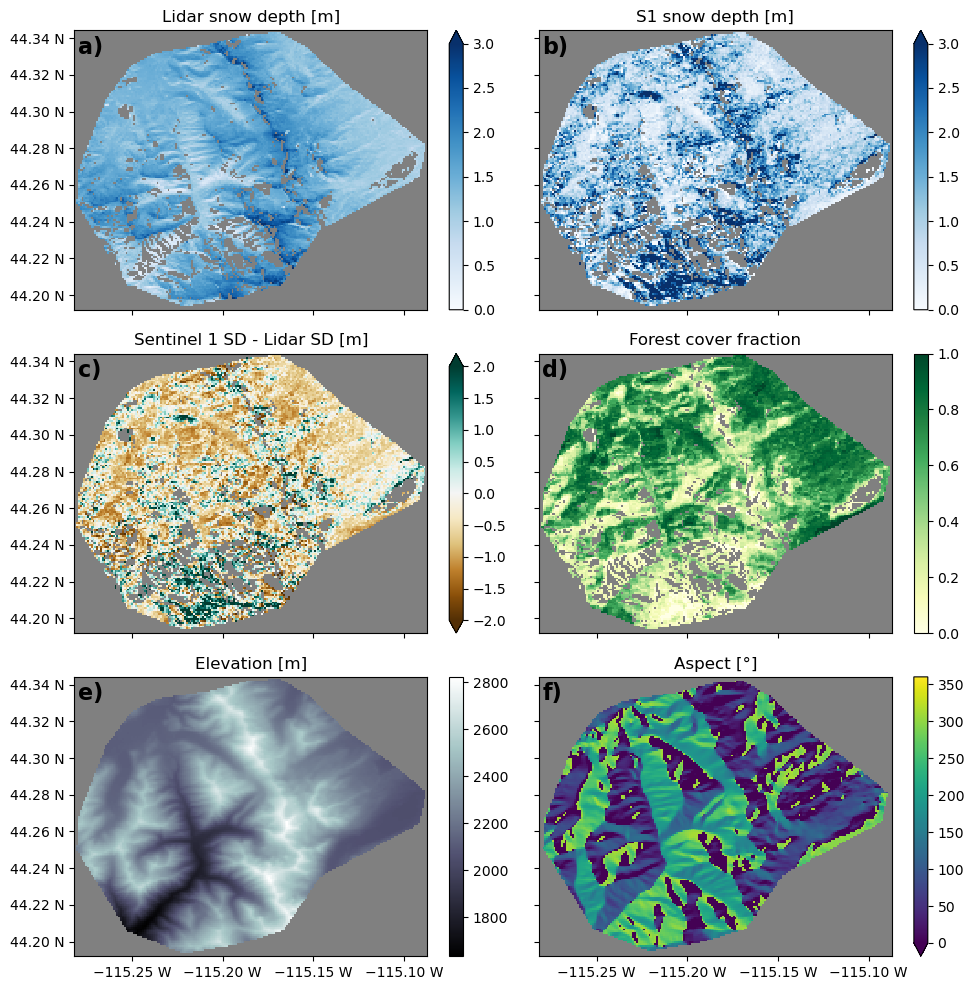

In [6]:
lidar = data['lidar-sd']
spicy = data['snow_depth'].sel(time='2021-03-15', method='nearest')
idx = (~lidar.isnull()) & (~spicy.isnull())
lidar = lidar.where(idx)
spicy = spicy.where(idx)
wet_snow = data['wet_snow'].sel(time='2021-03-15', method='nearest').where(idx)
inc_angle = data['s1'].sel(band = 'inc').sel(time = '2021-03-15', method = 'nearest').where(idx)
# conf_angle = data['confidence']

violin_ = pd.DataFrame()
violin_['lidar'] = lidar.values.flatten()
# violin_.loc[violin_['lidar']==0, 'lidar'] = np.nan
violin_['S1'] = spicy.values.flatten()
violin_['fcf'] = data['fcf'].where(idx).values.flatten()
violin_['elev'] = data['lidar-dem'].where(idx).values.flatten()
violin_['wet_snow'] = wet_snow.values.flatten()
violin_['inc_angle'] = np.rad2deg(inc_angle.values.flatten())
# violin_['conf_angle'] = np.rad2deg(conf_angle.values.flatten())
violin_['aspect'] = data['aspect'].where(idx).values.flatten()

violin_['sd_cat'] = pd.cut(violin_['lidar'], 
                           bins=[0, 1, 1.5, 2, 10],
                           labels=['0-1','1-1.5','1.5-2','>2'],
                           include_lowest=True)
violin_['fcf_cat'] = pd.cut(violin_['fcf'], 
                           bins=[0, 0.25, 0.5, 0.75, 1.0],
                           labels=['0-25','25-50','50-75','75-100'],
                           include_lowest=True)
violin_['elev_cat'] = pd.cut(violin_['elev'], 
                           bins=[1600, 1900, 2200, 2500, 2900],
                           labels=['1600-\n1900','1900-\n2200','2200-\n2500','2500-\n2900'],
                           include_lowest=True)
violin_['inc_cat'] = pd.cut(violin_['inc_angle'], 
                           bins=[0, 20, 40, 60, 80],
                           labels=['0-20','20-40','40-60','60-80'],
                           include_lowest=True)
violin_['aspect_cat'] = pd.cut(violin_['aspect'], 
                           bins=[-45, 45, 135, 225, 315],
                           labels=['N','E','S','W'],
                           include_lowest=True)
# violin_['conf_cat'] = pd.cut(violin_['conf_angle'], 
#                            bins=[0, 35, 40, 45, 50, 80],
#                            labels=['<35','35-40','40-45','45-50','>50'],
#                            include_lowest=True)


violin = violin_[['lidar','S1']].melt(var_name='Platform',value_name='snow_depth')
violin['wet_snow'] = np.tile(violin_['wet_snow'], 2)
violin['sd_cat'] = pd.Categorical(np.tile(violin_['sd_cat'].values, 2), categories=['0-1','1-1.5','1.5-2','>2'], ordered=True)
violin['fcf_cat'] = pd.Categorical(np.tile(violin_['fcf_cat'].values, 2), categories=['0-25','25-50','50-75','75-100'], ordered=True)
violin['elev_cat'] = pd.Categorical(np.tile(violin_['elev_cat'].values, 2), 
                                    categories=['1600-\n1900','1900-\n2200','2200-\n2500','2500-\n2900'], ordered=True)
violin['inc_cat'] = pd.Categorical(np.tile(violin_['inc_cat'].values, 2), categories=['0-20','20-40','40-60','60-80'], ordered=True)
violin['aspect_cat'] = pd.Categorical(np.tile(violin_['aspect_cat'].values, 2), categories=['N','E','S','W'], ordered=True)
# violin['conf_cat'] = pd.Categorical(np.tile(violin_['conf_cat'].values, 2), categories=['<35','35-40','40-45','45-50','>50'], ordered=True)


sd_cmap = plt.get_cmap('Blues')
diff_cmap = plt.get_cmap('BrBG')
fcf_cmap = plt.get_cmap('YlGn')
dem_cmap = plt.get_cmap('bone')
conf_cmap = plt.get_cmap('viridis')
for cmap in [sd_cmap, diff_cmap, fcf_cmap, dem_cmap, conf_cmap]:
    cmap.set_bad('gray')

vmin = min([np.nanmin(lidar.values), np.nanmin(spicy.values)])
vmax = max([np.nanmax(lidar.values), np.nanmax(spicy.values)])



# Plotting
fig, axes = plt.subplots(3, 2, figsize=(10,10))
# fig.suptitle('Banner Creek (Lidar extent)', y=1)
# First 3 panels - pcolormesh
lidar.plot(ax=axes[0,0], cmap=sd_cmap, vmin=vmin, vmax=3, cbar_kwargs={'label':''})#'Snow depth [m]'})
spicy.plot(ax=axes[0,1], cmap=sd_cmap, vmin=vmin, vmax=3, cbar_kwargs={'label':''})#'Snow depth [m]'})
diff = spicy - lidar
diff.plot(ax=axes[1,0], cmap=diff_cmap, vmin=-2, vmax=2, cbar_kwargs={'label':''})#'Snow depth difference [m]'})
data['fcf'].where(~pd.isnull(spicy)).plot(ax=axes[1,1], cmap=fcf_cmap, cbar_kwargs={'label':''})#'Forest cover fraction'})
data['lidar-dem'].plot(ax=axes[2,0], cmap=dem_cmap, cbar_kwargs={'label':''})#'Elevation [m]'})

data['aspect'].plot(ax = axes[2, 1], cmap = conf_cmap, vmin = 0, vmax = 360, cbar_kwargs={'label':''})
# data['wet_snow'].sel(time = '2021-03-15', method = 'nearest').where(~pd.isnull(spicy)).plot(ax=axes[2,1], cmap=fcf_cmap, cbar_kwargs={'label':''})
# np.rad2deg(inc_angle).plot(ax = axes[2, 1], cmap = conf_cmap, vmin = 0, vmax = 90, cbar_kwargs={'label':''})
# np.rad2deg(data['inc']).where(~pd.isnull(lidar)).plot(ax = axes[2, 1], cmap = conf_cmap, vmin = 0, vmax = 60, cbar_kwargs={'label':''})
# diff_coarse = lidar.coarsen(x = 5, y = 5, boundary = 'pad').mean() - spicy.coarsen(x = 5, y = 5, boundary = 'pad').mean()
# diff_coarse.plot(ax = axes[2, 1], cmap = diff_cmap, vmin = -2, vmax = 2, cbar_kwargs={'label':''})
# conf = np.rad2deg(data['confidence'].where(~pd.isnull(spicy), np.nan))
# conf.plot(ax=ax[2,1], cmap=conf_cmap, vmin=35, vmax=50, cbar_kwargs={'label':''})#'Confidence'})

# 4th panel - histogram comparison
# ax[1,1].hist(violin_['lidar'], bins=100, histtype='step', label='lidar', lw=1.5, color='#44739d')#sns.color_palette('deep')[0])
# ax[1,1].hist(violin_['spicy'], bins=100, histtype='step', label='spicy', lw=1.5, color='#d48640')#sns.color_palette('deep')[1])
# ax[1,1].legend(title='Platform')
# Titles for first 4
axes[0,0].set_title('Lidar snow depth [m]')
axes[0,1].set_title('S1 snow depth [m]')
axes[1,0].set_title('Sentinel 1 SD - Lidar SD [m]')
axes[1,1].set_title('Forest cover fraction')
axes[2,0].set_title('Elevation [m]')
axes[2,1].set_title('Aspect [°]')

master_xlim = axes[0,0].get_xlim()
master_ylim = axes[0,0].get_ylim()
master_xticks = np.array(axes[0,0].get_xticks())
master_yticks = np.array(axes[0,0].get_yticks())
master_xlabels = np.array(axes[0,0].get_xticklabels())
master_ylabels = np.array(axes[0,0].get_yticklabels())

for i, axx in enumerate(axes.flatten()):# [ax[0,0], ax[0,1], ax[1,0]]:
    # xticks = axx.get_xticks()
    axx.set_xlabel('')
    axx.set_ylabel('')
    # axx.tick_params(labelsize=10)
    # # axx.set_xticks(xticks)
    if i in [4, 5]:
        # print('before 4,5',master_xlabels)
        axx.set_xticks(master_xticks, labels=[l+' W' for l in [lab.get_text() for lab in master_xlabels]])
        # print('after 4,5',master_xlabels)
    # else:
    #     pass
    #     print('before 0-3',master_xlabels)
    #     axx.set_xticks(master_xticks, labels=np.tile([''], len(master_xticks)))
    #     print('after 0-3', master_xlabels)
    if i in [0]:
        # print('before 0',master_ylabels)
        axx.set_yticks(master_yticks, labels=[l+' N' for l in [lab.get_text() for lab in master_ylabels]])
        # print('after 0',master_ylabels)
    elif i in [2,4]:
        # print('before 2,4',master_ylabels)
        axx.set_yticks(master_yticks, labels=master_ylabels)
        # print('after 2,4',master_ylabels)

axes[0,0].set_xticks(master_xticks, labels=['']*6)
axes[0,1].set_xticks(master_xticks, labels=['']*6)
axes[1,0].set_xticks(master_xticks, labels=['']*6)
axes[1,1].set_xticks(master_xticks, labels=['']*6)
axes[0,1].set_xticks(master_xticks, labels=['']*6)
# ax[1,1].set_xticks(master_xticks, labels=master_xlabels)
# ax[2,1].set_xticks(master_xticks, labels=master_xlabels)

axes[0,1].set_yticks(master_yticks, labels=['']*len(master_yticks))
axes[1,1].set_yticks(master_yticks, labels=['']*len(master_yticks))
axes[2,1].set_yticks(master_yticks, labels=['']*len(master_yticks))
0
for ax, letter in zip(axes.flatten(), ['a','b','c','d','e','f']):
    ax.text(0.01, 0.98,f'{letter})', transform=ax.transAxes, ha = 'left', va = 'top', weight='bold', size = 16)


for ax in axes.flatten():
    ax.set_xlim(master_xlim)
    ax.set_ylim(master_ylim)

plt.tight_layout()
plt.savefig(fig_dir.joinpath('banner_maps.png'))

/var/folders/hn/hd92_2tj7rj8xghqt1qf0nhr2p1n49/T/ipykernel_72679/1487279196.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,1].set_xticklabels(['Wet','Dry'])
/var/folders/hn/hd92_2tj7rj8xghqt1qf0nhr2p1n49/T/ipykernel_72679/1487279196.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axx.set_xticklabels(new_labels)
/var/folders/hn/hd92_2tj7rj8xghqt1qf0nhr2p1n49/T/ipykernel_72679/1487279196.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axx.set_xticklabels(new_labels)
/var/folders/hn/hd92_2tj7rj8xghqt1qf0nhr2p1n49/T/ipykernel_72679/1487279196.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axx.set_xticklabels(new_labels)
/var/folders/

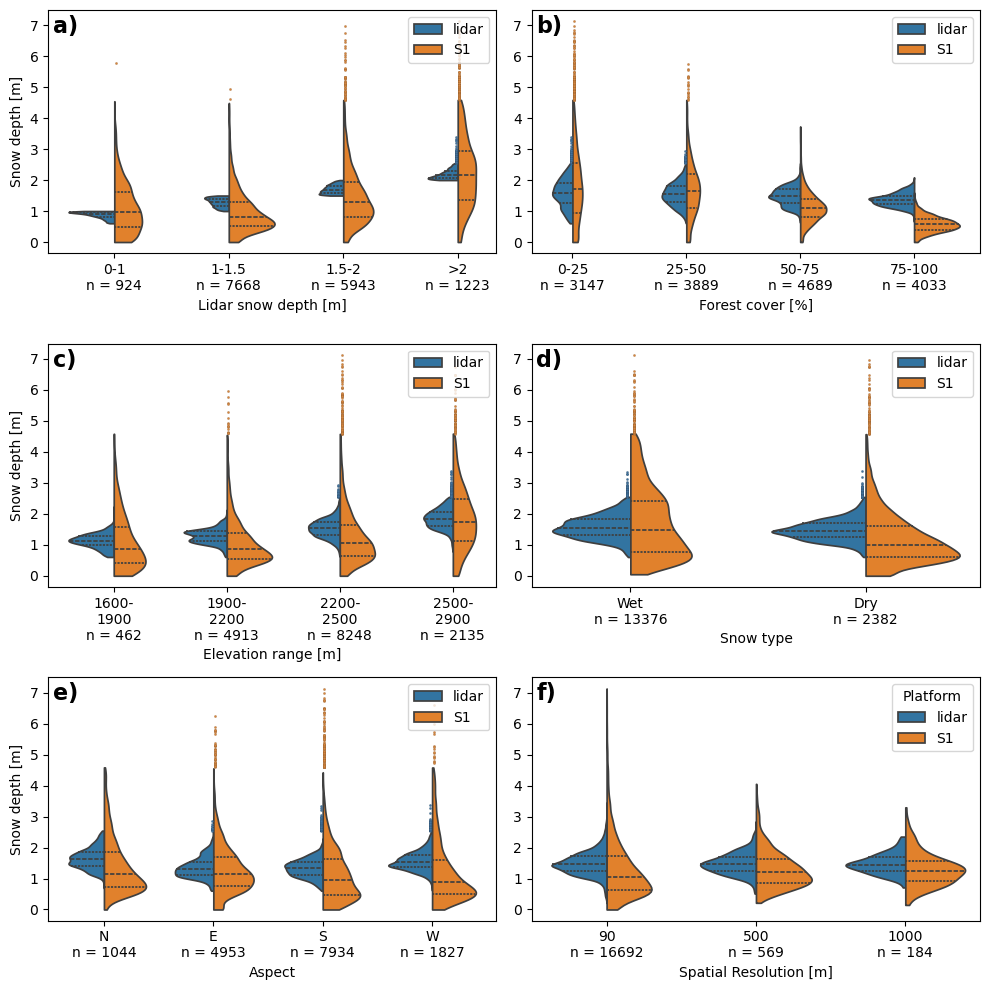

In [7]:
# Subset data
# drop NaN
violin.dropna(inplace=True)
# Save outliers for scatter plot
deep_lidar_idx = violin[(violin['snow_depth'] > violin_['lidar'].quantile(0.99)) & (violin['Platform'] == 'lidar')].index
deep_spicy_idx = violin[(violin['snow_depth'] > violin_['S1'].quantile(0.99)) & (violin['Platform'] == 'S1')].index
shallow_lidar_idx = violin[(violin['snow_depth'] < violin_['lidar'].quantile(0.01)) & (violin['Platform'] == 'lidar')].index
shallow_spicy_idx = violin[(violin['snow_depth'] < violin_['S1'].quantile(0.01)) & (violin['Platform'] == 'S1')].index
outlier_idx = deep_lidar_idx.union(deep_spicy_idx).union(shallow_lidar_idx).union(shallow_spicy_idx)
deep_outlier_idx = deep_lidar_idx.union(deep_spicy_idx)
violin_outliers = violin.loc[deep_outlier_idx]
# Drop outliers from main df
violin.drop(index=outlier_idx, inplace=True)

# Plotting

fig, ax = plt.subplots(3, 2, figsize=(10,10))
# Violin plots
sns.violinplot(data=violin, x='sd_cat', y='snow_depth', hue='Platform', split=True, inner='quartile', ax=ax[0,0], cut=0)
sns.violinplot(data=violin, x='fcf_cat', y='snow_depth', hue='Platform', split=True, inner='quartile', ax=ax[0,1], cut=0)
sns.violinplot(data=violin, x='elev_cat', y='snow_depth', hue='Platform', split=True, inner='quartile', ax=ax[1,0], cut=0)
sns.violinplot(data=violin, x='wet_snow', y='snow_depth', hue='Platform', split=True, inner='quartile', ax=ax[1,1], cut=0)
sns.violinplot(data=violin, x='aspect_cat', y='snow_depth', hue='Platform', split=True, inner='quartile', ax=ax[2,0], cut=0)
# sns.violinplot(data=violin, x='conf_cat', y='snow_depth', hue='Platform', split=True, inner='quartile', ax=ax[2,1], cut=0)
# Set wet snow labels before full label adjustment
ax[1,1].set_xticklabels(['Wet','Dry'])
# ax[0,0].legend(loc='upper left', title='Platform')

# Prepare x-coords to add outliers as scatter
for cat in ['sd_cat', 'fcf_cat', 'elev_cat','inc_cat']:
    d = dict([(y,x) for (x,y) in enumerate(violin_outliers[cat].cat.categories.values)])
    violin_outliers[cat+'_x'] = violin_outliers[cat].map(d)


# Add value counts to all violin plots
axes = [ax[0,0], ax[0,1], ax[1,0], ax[1,1], ax[2,0], ax[2,1]]
cols = ['sd_cat','fcf_cat','elev_cat','wet_snow', 'inc_cat']
x_labs = {'sd_cat':'Lidar snow depth [m]','fcf_cat':'Forest cover [%]','elev_cat':'Elevation range [m]','wet_snow':'Snow type',
          'inc_cat':'Aspect'}

for axx, col in zip(axes, cols):
    components = list(zip([lab.get_text() for lab in axx.get_xticklabels()],violin[violin.Platform=='lidar'][col].value_counts(sort=False).values))
    new_labels = [l[0]+f'\nn = {l[1]}' for l in components]
    axx.set_xticklabels(new_labels)
    axx.set_ylabel('Snow depth [m]')
    axx.set_xlabel(x_labs[col])
    # Add outliers
    if col != 'wet_snow':
        axx.scatter(violin_outliers.loc[violin_outliers['Platform']=='lidar', col+'_x'].astype(float)-0.015, 
                    violin_outliers.loc[violin_outliers['Platform']=='lidar', 'snow_depth'], 
                    color='#44739d', s=3, linewidths=0.05, edgecolors='k')
        axx.scatter(violin_outliers.loc[violin_outliers['Platform']=='S1', col+'_x'].astype(float)+0.015, 
                    violin_outliers.loc[violin_outliers['Platform']=='S1', 'snow_depth'], 
                    color='#d48640', s=3, linewidths=0.05, edgecolors='k')
    else:
        axx.scatter(violin_outliers.loc[violin_outliers['Platform']=='lidar', 'wet_snow'].astype(float)-0.015, 
                    violin_outliers.loc[violin_outliers['Platform']=='lidar', 'snow_depth'], 
                    color='#44739d', s=3, linewidths=0.05, edgecolors='k')
        axx.scatter(violin_outliers.loc[violin_outliers['Platform']=='S1', 'wet_snow'].astype(float)+0.015, 
                    violin_outliers.loc[violin_outliers['Platform']=='S1', 'snow_depth'], 
                    color='#d48640', s=3, linewidths=0.05, edgecolors='k')

ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[2,1].set_ylabel('')

for ax in axes:
    ax.legend(loc='upper right')

for ax, letter in zip(axes, ['a','b','c','d','e','f']):
    ax.text(0.01, 0.98,f'{letter})', transform=ax.transAxes, ha = 'left', va = 'top', weight='bold', size = 16)

# adding scale subplot
scale = pd.DataFrame()
spicy = data['snow_depth'].sel(time = '2021-03-15', method = 'nearest').where(idx)
lidar = data['lidar-sd'].where(idx)

scale['lidar'] = lidar.values.ravel()
scale['S1'] = spicy.values.ravel()
scale_violin = scale[['lidar','S1']].melt(var_name='Platform',value_name='snow_depth')
scale_violin['Spatial Resolution [m]'] = 100

scale = pd.DataFrame()
scale['lidar'] = lidar.coarsen(x=6, y = 6, boundary = 'pad').mean().values.ravel()
scale['S1'] = spicy.coarsen(x=6, y = 6, boundary = 'pad').mean().values.ravel()
coarse_violin = scale[['lidar','S1']].melt(var_name='Platform',value_name='snow_depth')
coarse_violin['Spatial Resolution [m]'] = 500

scale_violin = pd.concat([scale_violin, coarse_violin])

scale = pd.DataFrame()
scale['lidar'] = lidar.coarsen(x=11, y = 11, boundary = 'pad').mean().values.ravel()
scale['S1'] = spicy.coarsen(x=11, y = 11, boundary = 'pad').mean().values.ravel()
coarse_violin = scale[['lidar','S1']].melt(var_name='Platform',value_name='snow_depth')
coarse_violin['Spatial Resolution [m]'] = 1000

scale_violin = pd.concat([scale_violin, coarse_violin])

sns.violinplot(data = scale_violin.reset_index(), y = 'snow_depth', x = 'Spatial Resolution [m]', hue = 'Platform', split=True, inner='quartile', cut=0, ax= axes[-1])
scale_violin = scale_violin[scale_violin.Platform == 'lidar']
axes[-1].set_xticks([0,1,2],[f"90\nn = {len(scale_violin[scale_violin['Spatial Resolution [m]']== 100].dropna())}", f"500\nn = {len(scale_violin[scale_violin['Spatial Resolution [m]']== 500].dropna())}", f"1000\nn = {len(scale_violin[scale_violin['Spatial Resolution [m]']== 1000].dropna())}"])
axes[-1].set_ylabel('')
axes[-1].set_ylim()
# added scale subplot
plt.tight_layout()
plt.savefig(fig_dir.joinpath('banner_violins.png'))